In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import os
import math
import itertools
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter

%matplotlib inline

### Network Plots

In [5]:
def construct_daily_nets(input_file):
    """Read input file and return a dictionary of graphs where edge weight "pings" counts
    the number of times each pair has been observed.
    
    Data format and example:
        timestamp,user_a,user_b,rssi
        0,0,-1,0
        0,1,-1,0
        0,2,-1,0
    
    Some important points:
        -Time is quantized into 5-minute bins and timestamps are reported in the multiples of 300 seconds
        -In bins where userA was actively scanning, but found no other Bluetooth devices in proximity, 
         reported the alter ID as −1 and the received signal strength as 0
        -In bins where userA discovered other Bluetooth devices but not other study participants,
         reported the alter ID as −2 and the highest received signal strength measured.
"""
    counter = 0
    Gs = {}
    stats = {}
    for line in open(input_file):
        counter += 1
        # skip the first (header) line
        if counter > 1:
            # extract input
            line = line.rstrip().split(",")
            timestamp = int(line[0])
            user_a = int(line[1])
            user_b = int(line[2])
            rssi = int(line[3])
            day = timestamp // (24 * 60 * 60)

            # keep statistics for each day
            if day not in stats:
                stats[day] = {"pings":1, "empty":0, "other":0}
            else:
                stats[day]["pings"] += 1

            # create a graph for each day
            if day not in Gs:
                Gs[day] = nx.Graph()
            
            # if user_b is a person in the study, such that user_b >=0, update network
            if user_b >= 0:
                # construct daily graph if RSSI > -75
                if rssi >= -75:
                    # create new edge if needed
                    if not Gs[day].has_edge(user_a, user_b):
                        Gs[day].add_edge(user_a, user_b, pings = 1)
                    # update weight of existing edge
                    else:
                        weight = Gs[day].edges[user_a, user_b]["pings"]
                        Gs[day].add_edge(user_a, user_b, pings = weight + 1)
            
            # if user b is not a person in the study, update stats
            else:
                if user_b == -1:
                    stats[day]["empty"] += 1
                elif user_b == -2:
                    stats[day]["other"] += 1
                
    return (Gs, stats)

input_file = "bt_symmetric.csv"
(Gs, stats) = construct_daily_nets(input_file)

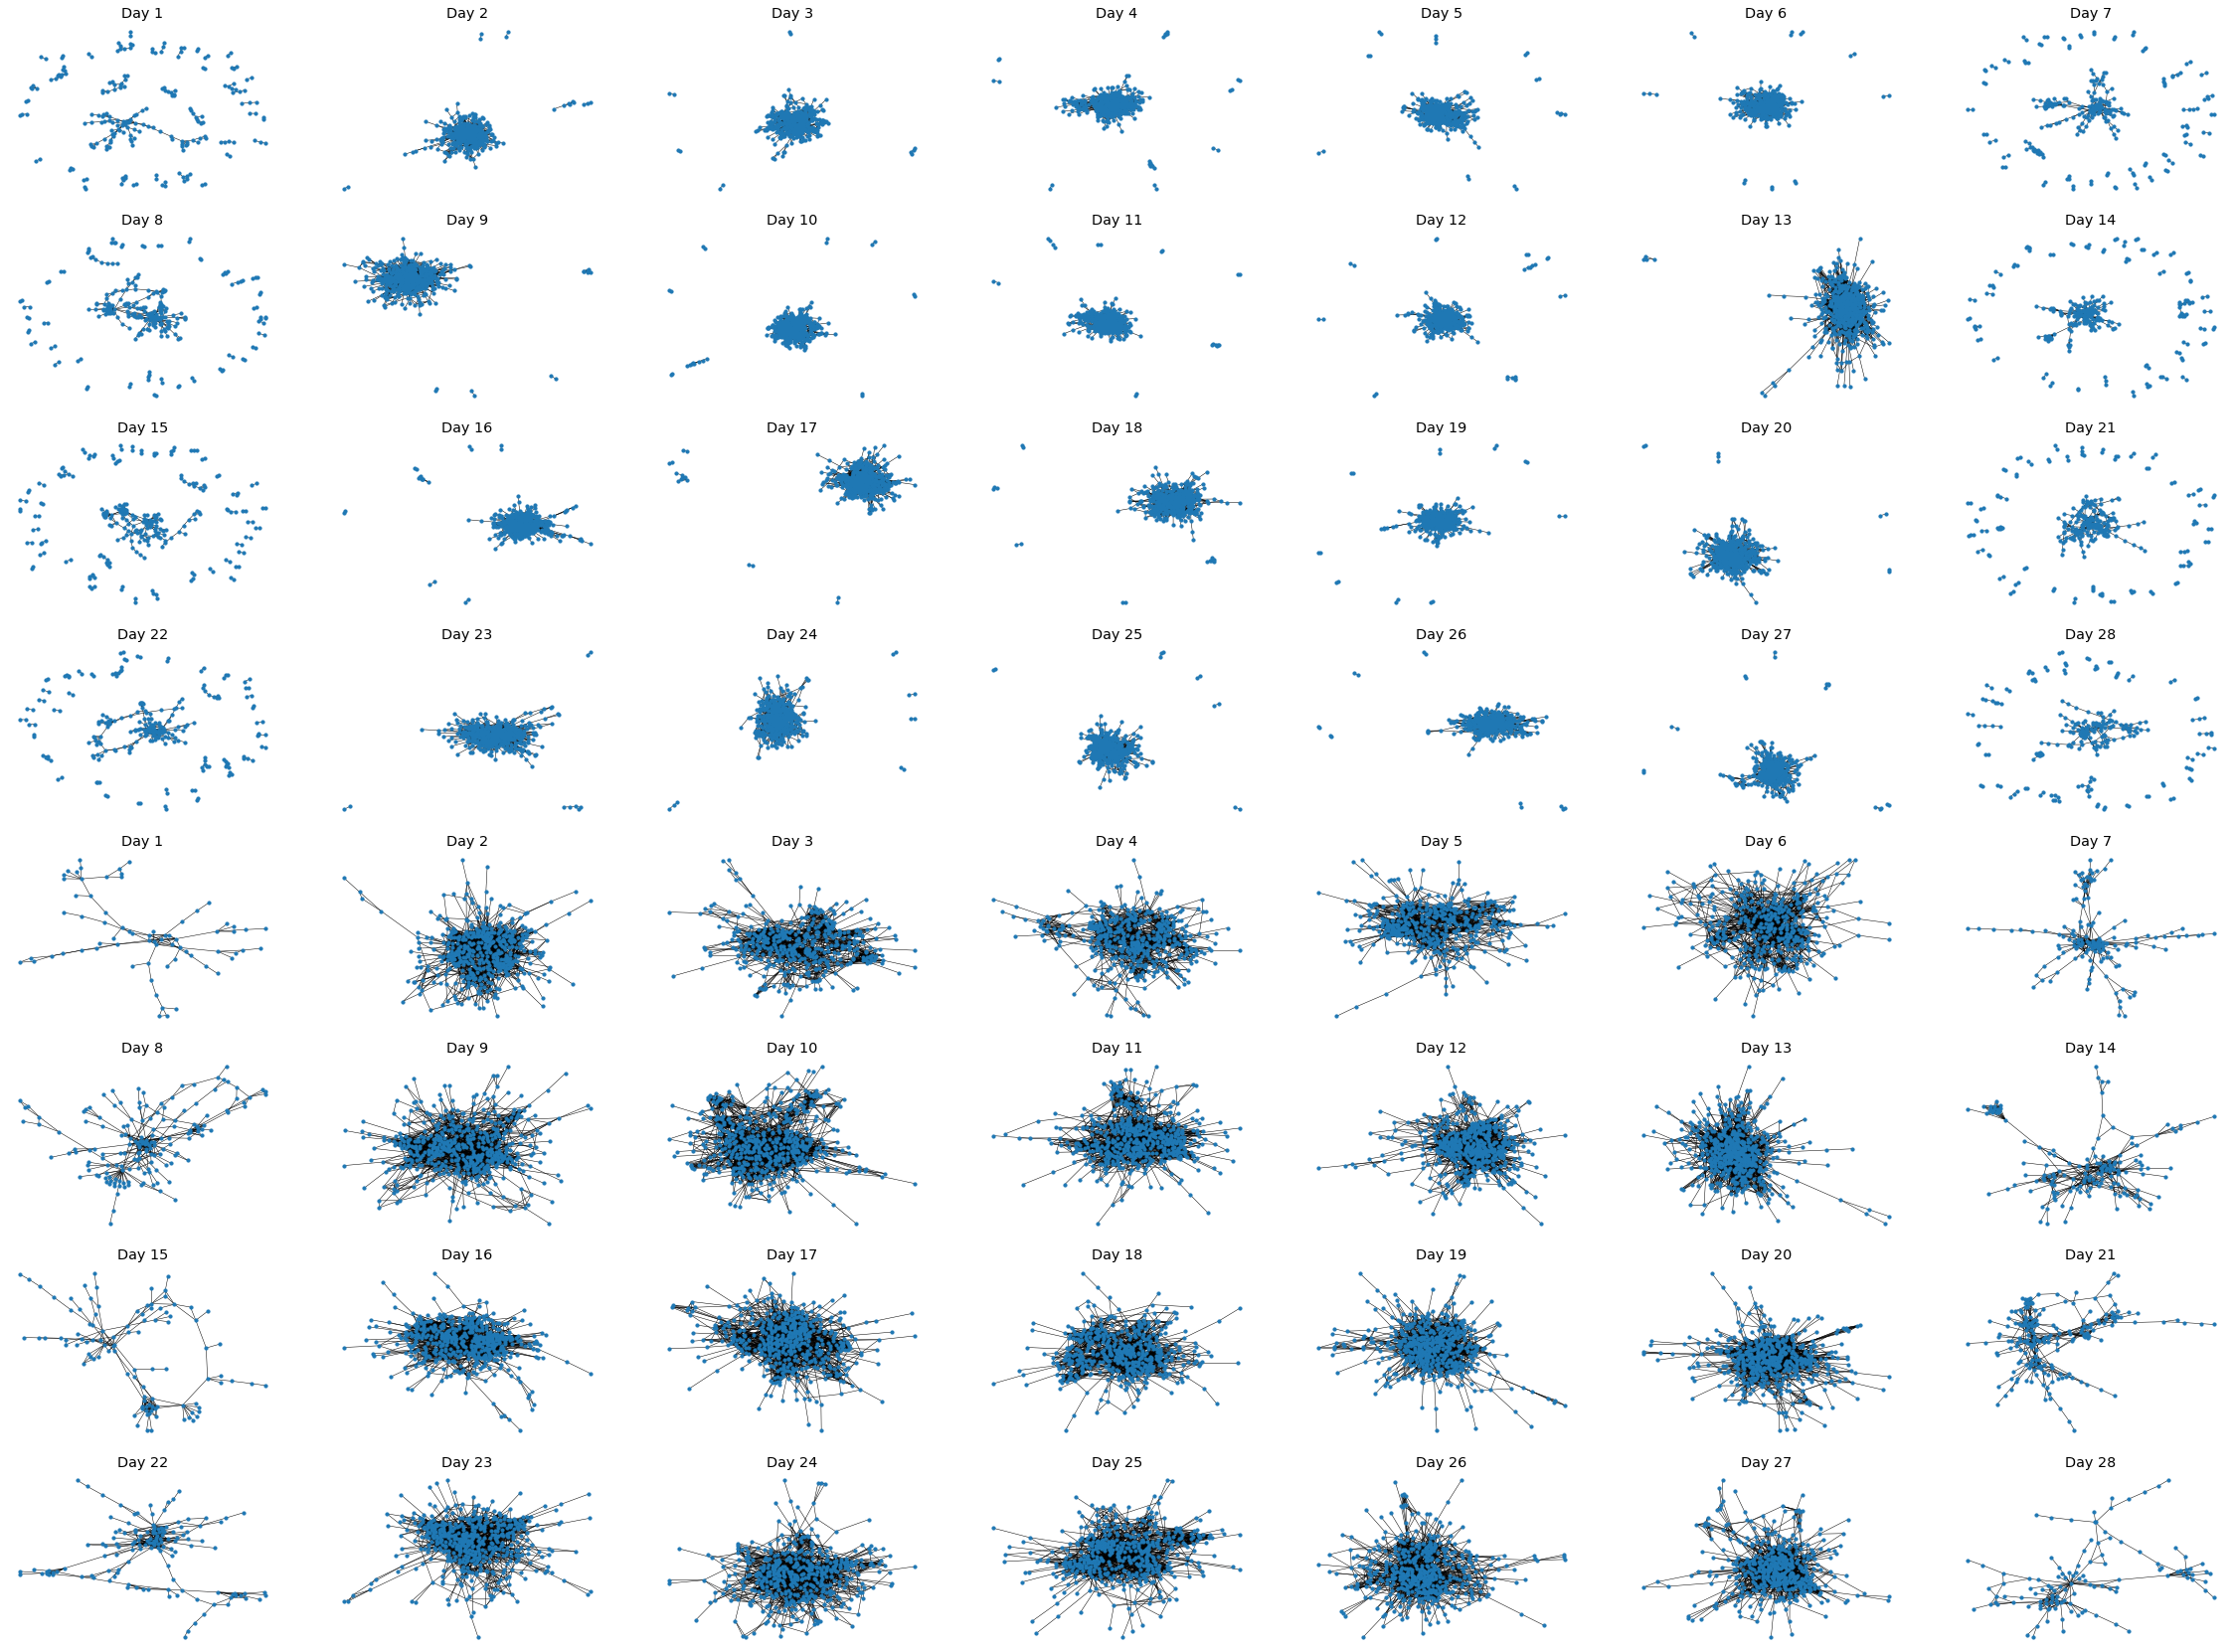

In [7]:
days = sorted(stats.keys())

mpl.rcParams['axes.titlesize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large'

f, axs = plt.subplots(8, 7, figsize = (40, 30))

for myp in range(2):
    for (i, day) in enumerate(days):
        row = i//7
        col = i-(row*7)
        # Plot networks
        if myp==0:
            nx.draw(Gs[day], node_size=10, width=0.5, ax = axs[row, col])
            axs[row, col].set_title("Day " + str(day+1))
            
        # Plot LCCs
        elif myp==1:
            lcc = max(nx.connected_components(Gs[day]), key=len)
            nx.draw(Gs[day].subgraph(lcc), node_size=10, width=0.5, ax = axs[row+4,col])
            axs[row+4,col].set_title("Day " + str(day+1))
            
#plt.savefig('Networks_LCCs_byDay_trans.eps', format = 'eps', transparent=True);

In [8]:
# Figure out the maximum number of connected components outside the LCC
nsubs = []
for day in days:
    lcc = max(nx.connected_components(Gs[day]), key=len)
    S = [Gs[day].subgraph(c).copy() for c in nx.connected_components(Gs[day]) if len(c)!=len(lcc)]
    nsubs.append(len(S))
    
max(nsubs)

51

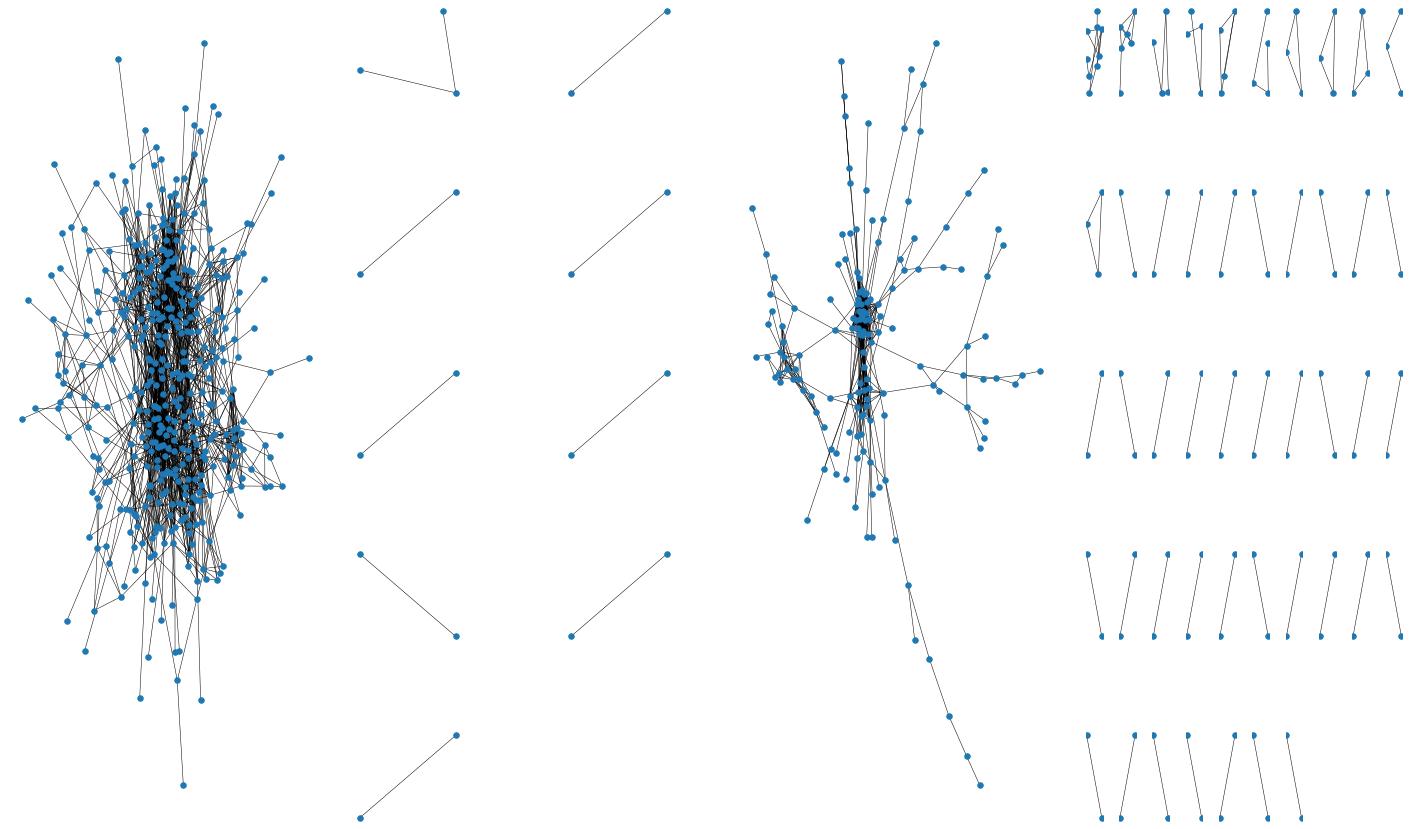

In [9]:
# Just plot one weekend and one weekday side-by-side
days = [5,6]

mpl.rcParams['axes.titlesize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large'

fig = plt.figure(figsize=(25, 15))
outer = gridspec.GridSpec(1,2, wspace=0.1, hspace=0.15)

for (i, day) in enumerate(days):
    lcc = max(nx.connected_components(Gs[day]), key=len)
    S = [Gs[day].subgraph(c).copy() for c in sorted(nx.connected_components(Gs[day]), key=len, reverse=True) if len(c)!=len(lcc)]
    
    # Set daily titles
    ax = plt.Subplot(fig, outer[i])
    #ax.set_title("Day " + str(day+1))
    ax.axis('off')
    fig.add_subplot(ax)
    
    inner1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    ax = plt.Subplot(fig, inner1[0])
    nx.draw(Gs[day].subgraph(lcc), node_size=30, width=0.5, ax=ax)
    fig.add_subplot(ax)
    
    cols = int(np.ceil(len(S)/5))
    inner2 = gridspec.GridSpecFromSubplotSpec(5, cols, subplot_spec=inner1[1], wspace=1, hspace=1)
    for j in range(5*cols):
        if j<=(len(S)-1):
            ax = plt.Subplot(fig, inner2[j])
            nx.draw(S[j], node_size=30, width=0.5, ax=ax, pos = nx.random_layout(S[j]))
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner2[j])
            nx.draw(nx.Graph(), node_size=30, width=0.5, ax=ax)
            fig.add_subplot(ax)

#plt.savefig('Networks_weekday_vs_weekend.eps', bbox_inches='tight', transparent=True);

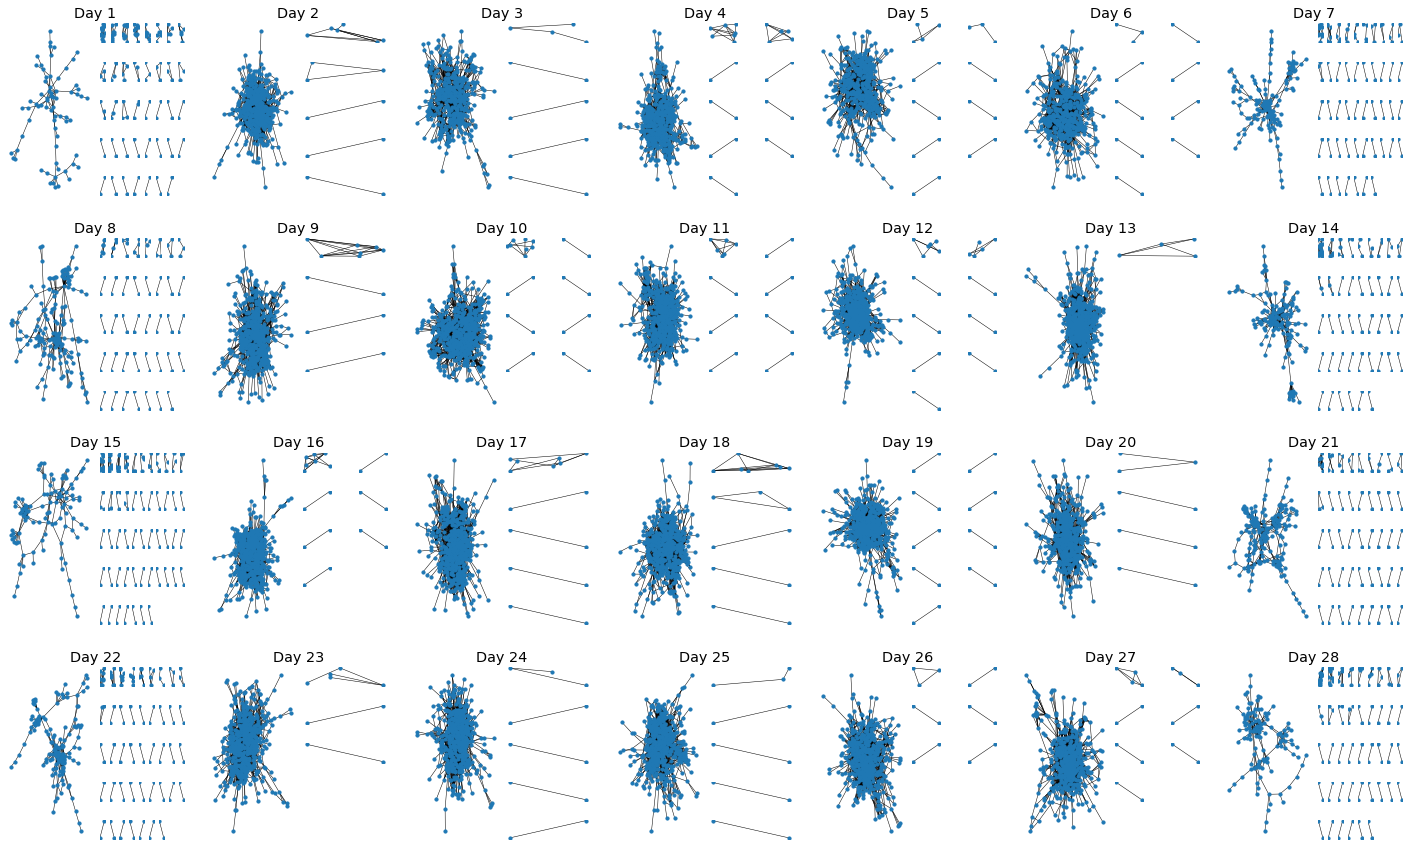

In [12]:
days = sorted(stats.keys())

mpl.rcParams['axes.titlesize'] = 'x-large'
mpl.rcParams['axes.labelsize'] = 'x-large'

fig = plt.figure(figsize=(25, 15))
outer = gridspec.GridSpec(4,7, wspace=0.15, hspace=0.25)

for (i, day) in enumerate(days):
    lcc = max(nx.connected_components(Gs[day]), key=len)
    S = [Gs[day].subgraph(c).copy() for c in sorted(nx.connected_components(Gs[day]), key=len, reverse=True) if len(c)!=len(lcc)]
    
    # Set daily titles
    ax = plt.Subplot(fig, outer[i])
    ax.set_title("Day " + str(day+1))
    ax.axis('off')
    fig.add_subplot(ax)
    
    inner1 = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    ax = plt.Subplot(fig, inner1[0])
    nx.draw(Gs[day].subgraph(lcc), node_size=10, width=0.5, ax=ax)
    fig.add_subplot(ax)
    
    cols = int(np.ceil(len(S)/5))
    inner2 = gridspec.GridSpecFromSubplotSpec(5, cols, subplot_spec=inner1[1], wspace=1, hspace=1)
    for j in range(5*cols):
        if j<=(len(S)-1):
            ax = plt.Subplot(fig, inner2[j])
            nx.draw(S[j], node_size=10, width=0.5, ax=ax, pos = nx.random_layout(S[j]))
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner2[j])
            nx.draw(nx.Graph(), node_size=10, width=0.5, ax=ax)
            fig.add_subplot(ax)

plt.savefig('Networks_LCCs_SidebySide_trans.eps', bbox_inches='tight', transparent=True);